# Goal
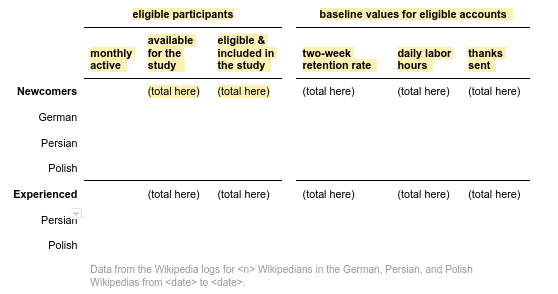

1. monthly-active - get from stats.wikimedia, do some subtraction of newcomers.
2. active users - active last 90 and have minimum 4 edits (before ores) - get from candidates table
3. meet quality standards* - get from candidates table
4. two-week-rention of control
5. daily lab



In [1]:
import os
# import civilservant
import pandas as pd

In [2]:
# cant get this working at the moment
# since its just static i will do it in sql and copy paste
# from civilservant import db
# db_engine = db.init_engine()
# print(db_engine) 
# db_engine.execute('show databases;').fetchall()
#db_engine.execute('select count(*) from candidates;').fetchall()

In [3]:
l_arrays = [['Newcomer', 'Newcomer', 'Newcomer', 'Newcomer', 'Experienced', 'Experienced', 'Experienced'], 
            ['Arabic', 'German', 'Polish', 'All newcomer', 'Persian', 'Polish', 'All experienced']]
mi = pd.MultiIndex.from_arrays(l_arrays, names=('Experience level', 'Language'))

In [4]:
mau = pd.DataFrame([[12281],[8555],[2414], [12281+8555+2414] ,[1899],[1985], [1899+1985]], index=mi, columns=['monthly active'])

In [5]:
# select lang, user_experience_level='bin_0', count(*) from candidates where lang != 'en' group by lang, user_experience_level='bin_0' order by user_experience_level='bin_0' desc;

# lang,user_experience_level='bin_0',count(*)
# ar,1,5936
# de,1,10476
# pl,1,2756
# fa,0,4648
# pl,0,8189

edit_qualifying_array = [
    [5936],
    [10476],
    [2756],
    [5936+10476+2756],
    [4648],
    [8189],
        [4648+8189],
]

edit_qualifying = pd.DataFrame(data=edit_qualifying_array,
                               index=mi,
                               columns=['potential candidates for inclusion']
                              )

In [6]:
# select lang, user_experience_level='bin_0', count(*) from candidates
# where lang != 'en' and user_editcount_quality>=4
# group by lang, user_experience_level='bin_0' order by user_experience_level='bin_0' desc, lang;

# lang,user_experience_level='bin_0',count(*)
# ar,1,3142
# de,1,5834
# pl,1,1653
# fa,0,2537
# pl,0,3384

quality_qualifying_array = [
    [3142],
    [5834],
    [1653],
    [3142+5834+1653],
    [2537],
    [3384],
    [2537+3384],
]

quality_qualifying = pd.DataFrame(data=quality_qualifying_array,
                               index=mi,
                               columns=['eligible and included in the study']
                              )

In [7]:
datadir = os.getenv('TRESORDIR')
tresorpath = 'CivilServant/projects/wikipedia-integration/gratitude-study/Data Drills/thankee/post_experiment_analysis'
fname = 'grat-thankee-all-pre-post-treatment-vars-max-cols.csv'
fpath = os.path.join(datadir, tresorpath, fname)

all_partici = pd.read_csv(fpath)

deleted_cond = all_partici['thanks.not.received.user.deleted']==True
multi_cond = all_partici['received.multiple.thanks']==True
unobservable_blocks = all_partici[(deleted_cond) | (multi_cond)]['randomization.block.id']

partici = all_partici[all_partici['randomization.block.id'].apply(lambda b: b not in unobservable_blocks)]

In [8]:
f'Len all participatns {len(all_partici)}, observable only {len(partici)}'

'Len all participatns 15558, observable only 15410'

In [9]:
control = partici[partici['randomization.arm']==0]

In [10]:
assert len(control)*2 == len(partici)

In [11]:
full_lang_names = {'ar':'Arabic', 'de': 'German', 'pl': 'Polish', 'fa': 'Persian'}
control['Language'] = control['lang'].apply(lambda l: full_lang_names[l])
control['Experience level'] = control['prev.experience.assignment'].apply(lambda b: 'Newcomer' if b=='bin_0' else 'Experienced')
control_aggs = control.groupby(['Experience level', 'Language',]).agg({'labor.hours.per.day.pre.treatment':pd.np.mean,
#                                                                  'labor.hours.per.day.post.treatment':pd.np.mean,
                                                                 'labor.hours.per.day.diff':pd.np.mean,
                                                                 'two.week.retention':pd.np.mean, 
                                                                 'thanks.sent':pd.np.mean})
control_all_aggs = control.groupby(['Experience level',]).agg({'labor.hours.per.day.pre.treatment':pd.np.mean,
#                                                                  'labor.hours.per.day.post.treatment':pd.np.mean,
                                                                 'labor.hours.per.day.diff':pd.np.mean,
                                                                 'two.week.retention':pd.np.mean, 
                                                                 'thanks.sent':pd.np.mean})

/home/paprika/.local/share/virtualenvs/experiment-action-controller-MJBx_Q7R/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/paprika/.local/share/virtualenvs/experiment-action-controller-MJBx_Q7R/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/paprika/.local/share/virtualenvs/experiment-action-controller-MJBx_Q7R/li

In [12]:
control_aggs = control_aggs.rename(columns={'labor.hours.per.day.pre.treatment':"daily labor hours, pre-treatment",
#                              'labor.hours.per.day.post.treatment':"daily labor hours, post-treatment",
                             'labor.hours.per.day.diff':"difference in daily labor hours during treatment period",
                             'two.week.retention':"two-week retention rate", 
                             'thanks.sent':"thanks sent"}, )
control_all_aggs = control_all_aggs.rename(columns={'labor.hours.per.day.pre.treatment':"daily labor hours, pre-treatment",
#                              'labor.hours.per.day.post.treatment':"daily labor hours, post-treatment",
                             'labor.hours.per.day.diff':"difference in daily labor hours during treatment period",
                             'two.week.retention':"two-week retention rate", 
                             'thanks.sent':"thanks sent"}, )

In [13]:
c_arrays = [
['baseline values for eligible accounts']*len(control_aggs.columns),
    control_aggs.columns.values
]
control_aggs_cols = pd.MultiIndex.from_arrays(c_arrays)

In [14]:
control_aggs.columns = control_aggs_cols
control_all_aggs.columns = control_aggs_cols

In [15]:
eligible_participants = pd.concat([mau, edit_qualifying, quality_qualifying,], axis=1)
cc_arrays = [
    ['eligible accounts']*len(eligible_participants.columns),
    eligible_participants.columns.values
]
eligible_participants_cols = pd.MultiIndex.from_arrays(cc_arrays)
eligible_participants.columns = eligible_participants_cols

In [16]:
control_aggs

baseline values for eligible accounts  \
                               daily labor hours, pre-treatment   
Experience level Language                                         
Experienced      Persian                               0.028206   
                 Polish                                0.060861   
Newcomer         Arabic                                0.020430   
                 German                                0.023823   
                 Polish                                0.026869   

                                                                                   \
                          difference in daily labor hours during treatment period   
Experience level Language                                                           
Experienced      Persian                                            0.007280        
                 Polish                                            -0.004368        
Newcomer         Arabic                                            -0.010108        
                 German                                            -0.011400        
                 Polish                                            -0.015002        

                                                               
                          two-week retention rate thanks sent  
Experience level Language                                      
Experienced      Persian                 0.307309    0.264120  
                 Polish                  0.442308    0.348901  
Newcomer         Arabic                  0.110020    0.032089  
                 German                  0.181785    0.051833  
                 Polish                  0.194614    0.037944

In [17]:
c_a_arrays = [control_all_aggs.index.values, [f'All {w.lower()}' for w in control_all_aggs.index.values] ]
control_all_aggs.index = pd.MultiIndex.from_arrays(c_a_arrays)

In [18]:
control_all_aggs

baseline values for eligible accounts  \
                                 daily labor hours, pre-treatment   
Experienced All experienced                              0.046080   
Newcomer    All newcomer                                 0.023289   

                                                                                     \
                            difference in daily labor hours during treatment period   
Experienced All experienced                                           0.000904        
Newcomer    All newcomer                                             -0.011592        

                                                                 
                            two-week retention rate thanks sent  
Experienced All experienced                0.381203    0.310526  
Newcomer    All newcomer                   0.162141    0.043608

In [19]:
caggs = pd.concat([control_all_aggs, control_aggs])

In [20]:
eligible_participants

eligible accounts  \
                                    monthly active   
Experience level Language                            
Newcomer         Arabic                      12281   
                 German                       8555   
                 Polish                       2414   
                 All newcomer                23250   
Experienced      Persian                      1899   
                 Polish                       1985   
                 All experienced              3884   

                                                                     \
                                 potential candidates for inclusion   
Experience level Language                                             
Newcomer         Arabic                                        5936   
                 German                                       10476   
                 Polish                                        2756   
                 All newcomer                                 19168   
Experienced      Persian                                       4648   
                 Polish                                        8189   
                 All experienced                              12837   

                                                                     
                                 eligible and included in the study  
Experience level Language                                            
Newcomer         Arabic                                        3142  
                 German                                        5834  
                 Polish                                        1653  
                 All newcomer                                 10629  
Experienced      Persian                                       2537  
                 Polish                                        3384  
                 All experienced                               5921

In [21]:
table1 = pd.concat([eligible_participants, caggs], axis=1)

In [22]:
table1 = table1.sort_index(ascending=False)

In [23]:
table1.to_html(float_format='{:,.3f}'.format)

'<table border="1" class="dataframe">\n  <thead>\n    <tr>\n      <th></th>\n      <th></th>\n      <th colspan="3" halign="left">eligible accounts</th>\n      <th colspan="4" halign="left">baseline values for eligible accounts</th>\n    </tr>\n    <tr>\n      <th></th>\n      <th></th>\n      <th>monthly active</th>\n      <th>potential candidates for inclusion</th>\n      <th>eligible and included in the study</th>\n      <th>daily labor hours, pre-treatment</th>\n      <th>difference in daily labor hours during treatment period</th>\n      <th>two-week retention rate</th>\n      <th>thanks sent</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th rowspan="4" valign="top">Newcomer</th>\n      <th>Polish</th>\n      <td>2414</td>\n      <td>2756</td>\n      <td>1653</td>\n      <td>0.027</td>\n      <td>-0.015</td>\n      <td>0.195</td>\n      <td>0.038</td>\n    </tr>\n    <tr>\n      <th>German</th>\n      <td>8555</td>\n      <td>10476</td>\n      <td>5834</td>\n      <td>0.

In [24]:
table1.to_clipboard(excel=False, float_format='{:,.3f}'.format)

In [25]:
print(table1.to_string(float_format='{:,.3f}'.format))

                            eligible accounts                                                                       baseline values for eligible accounts                                                                                            
                               monthly active potential candidates for inclusion eligible and included in the study      daily labor hours, pre-treatment difference in daily labor hours during treatment period two-week retention rate thanks sent
Newcomer    Polish                       2414                               2756                               1653                                 0.027                                                  -0.015                   0.195       0.038
            German                       8555                              10476                               5834                                 0.024                                                  -0.011                   0.182       0.052
            Arab

# misc

In [118]:
partici[partici['complier.app.any.reason']==True].sort_values('randomization.block.id')

,created.dt,randomization.arm,randomization.condition,removed.dt,metadata.json,lang,user.name,randomization.block.id,num.errors,number.skips.received,...,prev.experience.treatment,year,has.email,thanks.not.received.skipped,thanks.not.received.not.seen,thanks.not.received.error,thanks.not.received.user.deleted,received.multiple.thanks,complier.app.any.reason,complier
211,2019-07-30 23:50:43,1,thankee,NaN,"{'sync_object': {'lang': 'ar', 'user_id': 1666...",ar,رهف الوحش,2,0.0,1.0,...,bin_90,2019.0,True,False,False,False,False,False,True,False
977,2019-07-30 23:50:43,1,thankee,NaN,"{'sync_object': {'lang': 'ar', 'user_id': 1691...",ar,Mavdy Sameh,5,0.0,0.0,...,bin_0,2019.0,True,False,False,False,False,False,True,False
731,2019-07-30 23:50:43,1,thankee,NaN,"{'sync_object': {'lang': 'ar', 'user_id': 1683...",ar,Sedramously,11,0.0,0.0,...,bin_90,2019.0,True,False,False,False,False,False,True,False
465,2019-07-30 23:50:43,1,thankee,NaN,"{'sync_object': {'lang': 'ar', 'user_id': 1674...",ar,Baker esam,12,0.0,0.0,...,bin_90,2019.0,True,False,False,False,False,False,True,False
1105,2019-07-30 23:50:43,1,thankee,NaN,"{'sync_object': {'lang': 'ar', 'user_id': 1696...",ar,معتصم الهواري,18,0.0,0.0,...,bin_0,2019.0,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3139,2020-01-22 00:53:49,1,thankee,NaN,"{'sync_object': {'lang': 'de', 'user_id': 3075...",de,DannyS712,7563,0.0,1.0,...,bin_365,2018.0,True,False,False,False,False,False,True,False
5284,2020-01-22 00:53:49,1,thankee,NaN,"{'sync_object': {'lang': 'de', 'user_id': 3253...",de,BücherschubseSarah,7565,0.0,1.0,...,bin_180,2019.0,True,False,False,False,False,False,True,False
7616,2020-01-22 00:53:50,1,thankee,NaN,"{'sync_object': {'lang': 'de', 'user_id': 3341...",de,Brpr337,7566,0.0,0.0,...,bin_0,2019.0,True,False,False,False,False,False,True,False
7286,2020-01-22 00:53:51,1,thankee,NaN,"{'sync_object': {'lang': 'de', 'user_id': 3327...",de,Jean-Hyacinthe,7569,0.0,0.0,...,bin_90,2019.0,True,False,False,False,False,False,True,False
